**Anomaly Detection Project**

The Python script below creates a CSV file with 500 data points, of which 450 are inliers (normally distributed) and 50 are outliers (uniformly distributed). The data points will be saved in a CSV file.

In [1]:
import numpy as np
import pandas as pd

# Parameters for data generation
n_inliers = 450  # 90% inliers
n_outliers = 50  # 10% outliers

# Generating data for inliers (normal distribution)
inliers = np.random.normal(loc=0, scale=1, size=(n_inliers, 3))

# Generating data for outliers (uniform distribution)
outliers = np.random.uniform(low=-5, high=5, size=(n_outliers, 3))

# Combining inliers and outliers data
features = np.vstack([inliers, outliers])
labels = np.hstack([np.zeros(n_inliers), np.ones(n_outliers)])  # 0 for inliers, 1 for outliers

# Shuffling the data
indices = np.arange(len(labels))
np.random.shuffle(indices)
features = features[indices]
labels = labels[indices]

# Creating a DataFrame with features and labels
columns = ["feature1", "feature2", "feature3", "label"]
data = pd.DataFrame(features, columns=columns[:-1])
data["label"] = labels

# Saving the data to a CSV file
file_path = "generated_dataset.csv"
data.to_csv(file_path, index=False)

# Displaying the saved file location
print(f"The CSV file has been saved at the location: {file_path}")


The CSV file has been saved at the location: generated_dataset.csv


In the dataset we created, with inliers (normal points) distributed normally and outliers (anomalies) uniformly distributed over a wide range, it is more likely to encounter local anomalies. This is because anomalies (outliers) are placed around extreme values and do not form compact groups but are instead spread across the entire dataset.

**PYOD Installation**

In [ ]:
!pip install pyod

**K-Nearest Neighbors (k-NN)** is an algorithm based on the neighborhood of data points. In the context of anomaly detection, this algorithm evaluates a data point in relation to its closest points in the dataset. Points that are far from their neighbors are considered anomalies. The algorithm works as follows:
- Each point in the dataset is evaluated based on the distances to its closest
k points (neighbors).
- If a point has significantly larger distances to its neighbors compared to other points, it is considered an anomaly.

**ABOD (Angle-Based Outlier Detection)** is an anomaly detection method based on a geometric principle: identifying data points that form an unusual angle with their neighbors in the dataset. The core idea of ABOD is that anomalies can be detected by evaluating the angles between the vectors connecting a data point to its nearest neighbors. If a point forms a significantly different angle compared to most other points in its vicinity, it is considered an anomaly.


In [ ]:
from pyod.models.knn import KNN   # kNN detector
from pyod.models.abod import ABOD  # ABOD detector

Data Manipulation

In [ ]:
import pandas as pd
from pyod.utils.data import evaluate_print
from pyod.utils.example import visualize

# Parameters
csv_file = "generated_dataset.csv"
n_train = 300  # number of training points
n_test = 200  # number of testing points

# Load the CSV file
data = pd.read_csv(csv_file)

# Split the features and labels
X = data.iloc[:, :-2].values  # All columns except the last TWO (features)
y = data.iloc[:, -1].values   # The last column (labels)

# Split into training and testing sets
X_train, X_test = X[:n_train], X[n_train:n_train + n_test]
y_train, y_test = y[:n_train], y[n_train:n_train + n_test]

Implementation of each method and the adjustments made.

In [ ]:
# Initialize kNN and ABOD detectors
clf_knn = KNN()
clf_abod = ABOD()

# Train kNN detector
clf_knn.fit(X_train)
y_train_pred_knn = clf_knn.labels_  # binary labels (0: inliers, 1: outliers)
y_train_scores_knn = clf_knn.decision_scores_  # raw outlier scores

y_test_pred_knn = clf_knn.predict(X_test)  # outlier labels (0 or 1)
y_test_scores_knn = clf_knn.decision_function(X_test)  # outlier scores
y_test_pred_knn, y_test_pred_confidence_knn = clf_knn.predict(X_test, return_confidence=True)

# Train ABOD detector
clf_abod.fit(X_train)
y_train_pred_abod = clf_abod.labels_  # binary labels (0: inliers, 1: outliers)
y_train_scores_abod = clf_abod.decision_scores_  # raw outlier scores

y_test_pred_abod = clf_abod.predict(X_test)  # outlier labels (0 or 1)
y_test_scores_abod = clf_abod.decision_function(X_test)  # outlier scores
y_test_pred_abod, y_test_pred_confidence_abod = clf_abod.predict(X_test, return_confidence=True)


Evaluation of the performance of the two anomaly detection methods used (k-NN and ABOD) based on specific performance measures: ROC and Precision @ Rank n.

In [ ]:
from pyod.utils.data import evaluate_print
# Evaluate kNN and ABOD using ROC and Precision @ Rank n
print("\nOn Training Data (kNN):")
evaluate_print("kNN", y_train, y_train_scores_knn)

print("\nOn Test Data (kNN):")
evaluate_print("kNN", y_test, y_test_scores_knn)

print("\nOn Training Data (ABOD):")
evaluate_print("ABOD", y_train, y_train_scores_abod)

print("\nOn Test Data (ABOD):")
evaluate_print("ABOD", y_test, y_test_scores_abod)


On Training Data (kNN):
kNN ROC:0.9352, precision @ rank n:0.7742

On Test Data (kNN):
kNN ROC:0.8849, precision @ rank n:0.7368

On Training Data (ABOD):
ABOD ROC:0.9233, precision @ rank n:0.7742

On Test Data (ABOD):
ABOD ROC:0.8401, precision @ rank n:0.5789


Results Visualization

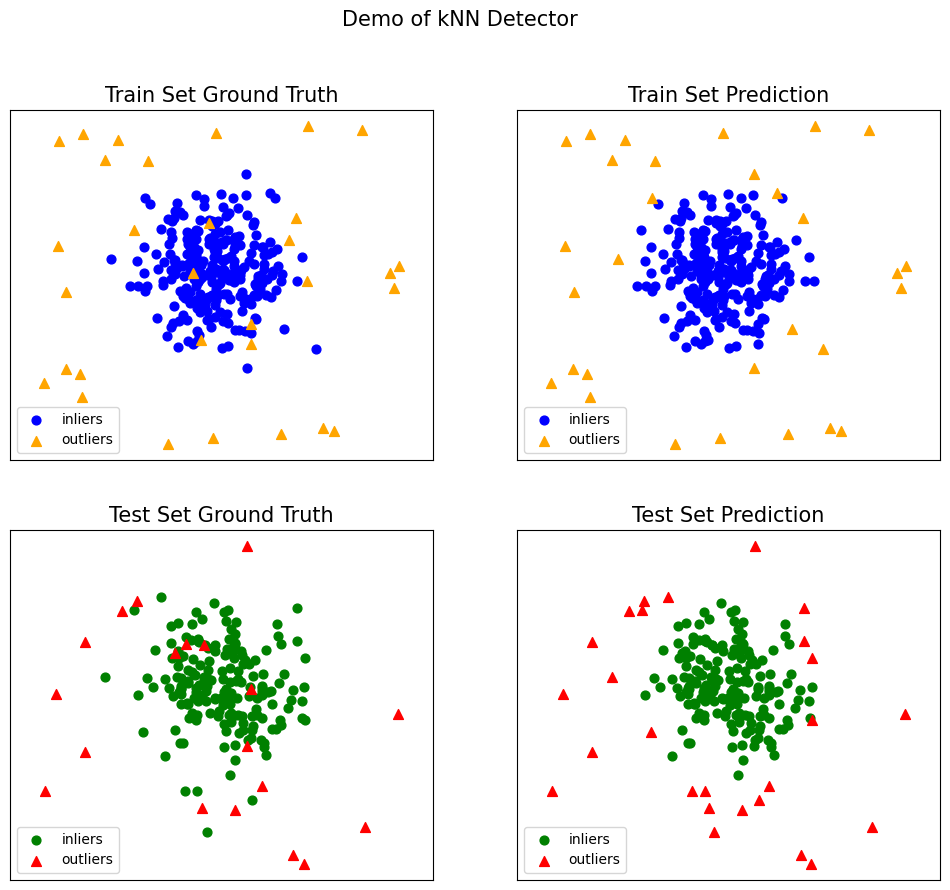

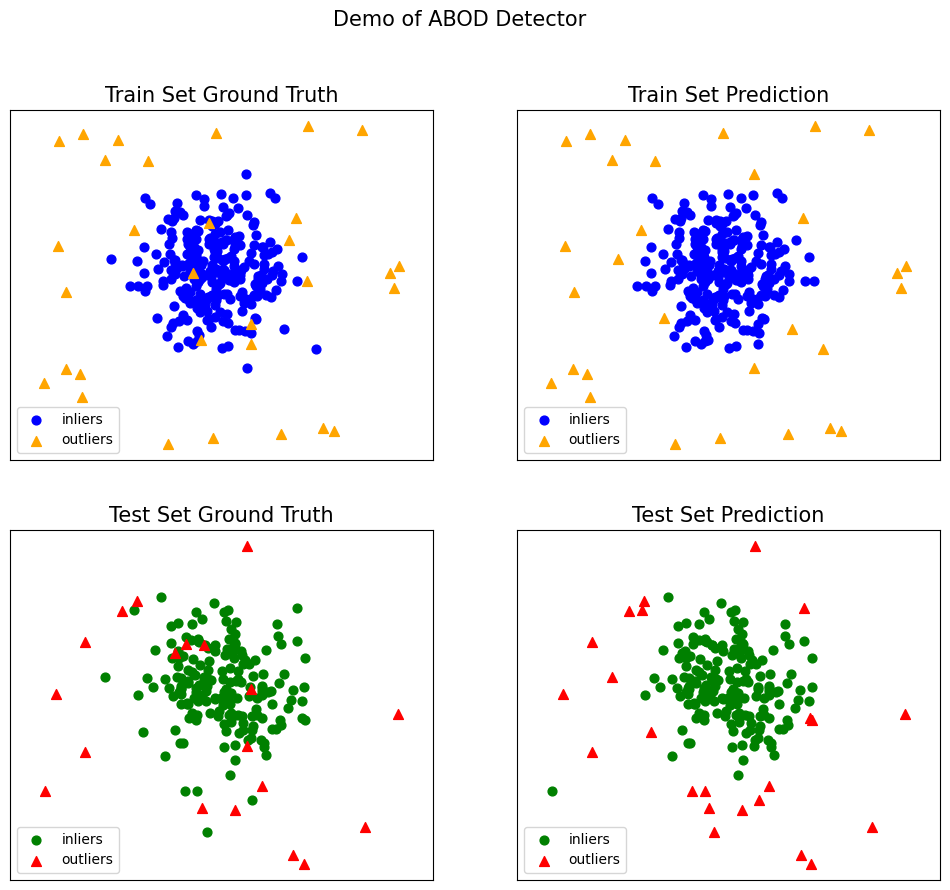

In [ ]:
# Visualize the results
visualize("kNN", X_train, y_train, X_test, y_test, y_train_pred_knn,
          y_test_pred_knn, show_figure=True, save_figure=False)

visualize("ABOD", X_train, y_train, X_test, y_test, y_train_pred_abod,
          y_test_pred_abod, show_figure=True, save_figure=False)


Calculation of the **Confusion Matrix**

In [ ]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, f1_score, confusion_matrix

def calculate_metrics(y_true, y_pred):
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    TP, FP, FN, TN = cm.ravel()  # Extract confusion matrix components

    # Calculate Precision
    precision = precision_score(y_true, y_pred)

    # Calculate Recall (Sensitivity)
    recall = recall_score(y_true, y_pred)

    # Calculate Specificity
    specificity = TN / (TN + FP)

    # Calculate Accuracy
    accuracy = accuracy_score(y_true, y_pred)

    # Calculate F1 Score
    f1 = f1_score(y_true, y_pred)

    return precision, recall, specificity, accuracy, f1, cm

# For kNN model
precision_knn, recall_knn, specificity_knn, accuracy_knn, f1_knn, cm_knn = calculate_metrics(y_test, y_test_pred_knn)
print("\nMetrics for kNN:")
print(f"Precision: {precision_knn}")
print(f"Recall (Sensitivity): {recall_knn}")
print(f"Specificity: {specificity_knn}")
print(f"Accuracy: {accuracy_knn}")
print(f"F1 Score: {f1_knn}")
print(f"Confusion Matrix:\n{cm_knn}")

# For ABOD model
precision_abod, recall_abod, specificity_abod, accuracy_abod, f1_abod, cm_abod = calculate_metrics(y_test, y_test_pred_abod)
print("\nMetrics for ABOD:")
print(f"Precision: {precision_abod}")
print(f"Recall (Sensitivity): {recall_abod}")
print(f"Specificity: {specificity_abod}")
print(f"Accuracy: {accuracy_abod}")
print(f"F1 Score: {f1_abod}")
print(f"Confusion Matrix:\n{cm_abod}")



Metrics for kNN:
Precision: 0.8888888888888888
Recall (Sensitivity): 0.8888888888888888
Specificity: 0.8888888888888888
Accuracy: 0.98
F1 Score: 0.8888888888888888
Confusion Matrix:
[[90  1]
 [ 1  8]]

Metrics for ABOD:
Precision: 0.6666666666666666
Recall (Sensitivity): 0.8888888888888888
Specificity: 0.6666666666666666
Accuracy: 0.95
F1 Score: 0.7619047619047619
Confusion Matrix:
[[87  4]
 [ 1  8]]


**Interpretation of the Results. Conclusions.**

It is observed that the kNN method performs better than the ABOD method, regardless of how the precision of the methods was calculated.

**Bibliography**

https://pyod.readthedocs.io/en/latest/
Machine Learning Techniques Course, I. Necoară